# Generating the `postal-codes-austria`

see README.md for more details and pre-conditions

## Imports

In [1]:
from matplotlib import pyplot as plt
import cv2
from pathlib import Path
import statistics
import numpy as np
import pytesseract
import re
from IPython.display import clear_output
import shapefile
import xml.etree.ElementTree as ET

## Input File

Image shape (19866, 28086, 3)


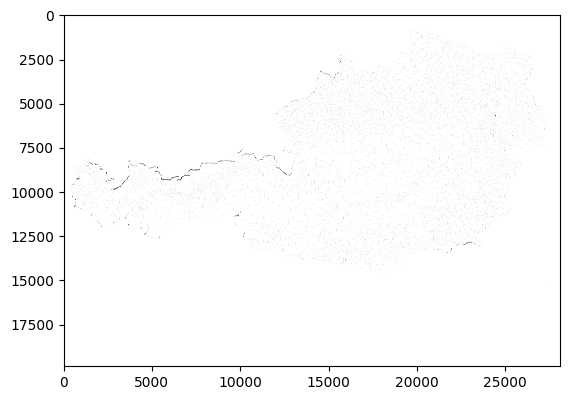

In [2]:
# Read the image
img = cv2.imread(str(Path('./input/map.png')))

if img is None:
    raise FileNotFoundError(f"Could not read the image file")

print("Image shape", img.shape)
plt.imshow(img)

## Regions of Interest

Rendering the whole image takes quite long because of it's high resolution (and also matplotlib is quite slow).

Therefore we'll define some regions of interest, which are easier to inspect

In [3]:
def show_region(img, ax, posX, posY, size, title):
    xlim = [round(posX-size/2), round(posX+size/2)]
    ylim = [round(posY-size/2), round(posY+size/2)]
    
    cropped_img = img[ylim[0]:ylim[1], xlim[0]:xlim[1]]
    ax.imshow(cropped_img, interpolation="antialiased")
    ax.set_title(title)

def show_regions(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    
    show_region(image, axes[0,0], 21400, 11000, 500, 'Graz')
    show_region(image, axes[0,1], 24500, 5000, 1200, 'Wien')
    show_region(image, axes[1,0], 7000, 10000, 800, 'Innsbruck')
    show_region(image, axes[1,1], 12800, 7500, 1300, 'Salzburg')
    plt.show()

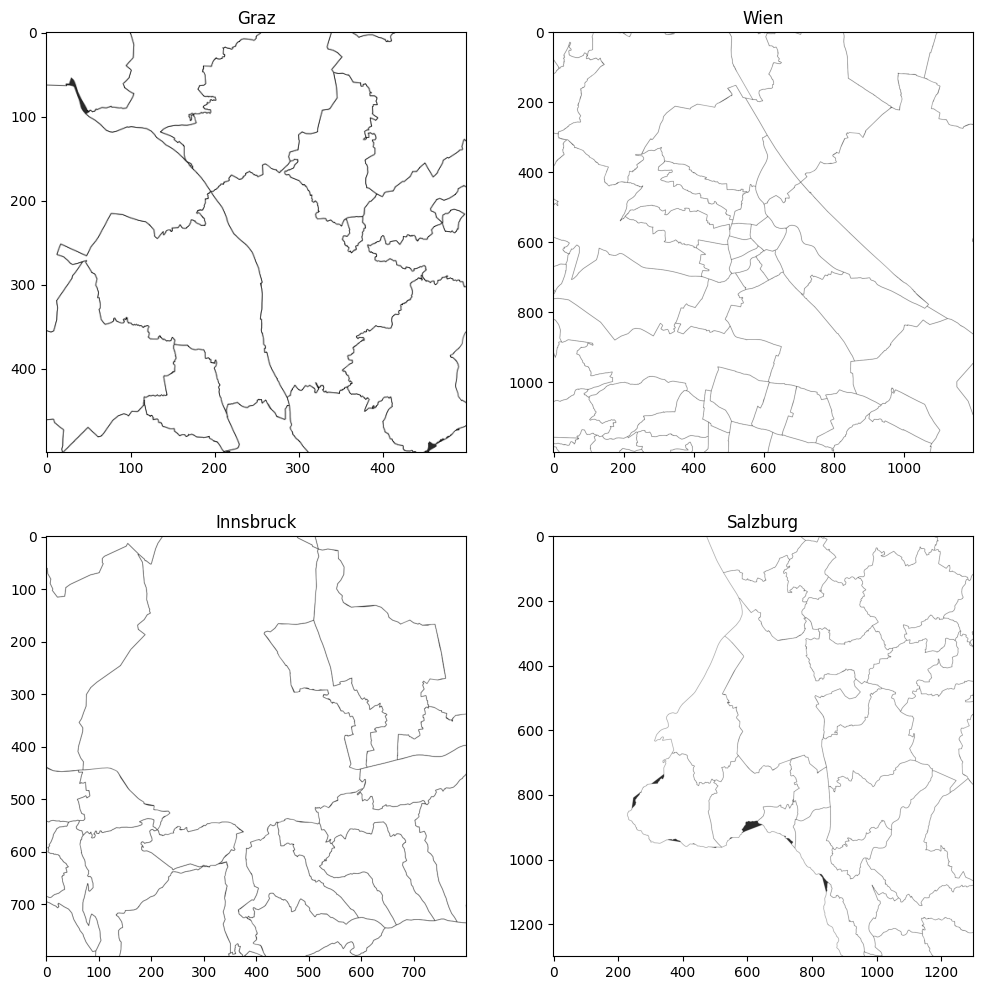

In [4]:
show_regions(img)

## Number of Postal Codes in Austria

Note: According to [gv.at: Österreichische Postleitzahlen](https://edm.gv.at/edm_portal/redaList.do;jsessionid=53D0AE0F9756E4C9AAD48CC07614BCE0?seqCode=598c5vaxpkprtj&d-49520-p=4&display=plain) there are currently (17.10.2024) **2236 postal codes in austria** => Therefore we are trying to find more than 2236 contours in the image

## Find Postal Code Contours/Areas

We are using the `findContours()` function from OpenCV. 

Typically some preprocessing is needed to make life easier for the `findContours()` function.

The preprocessing typically consists of the following steps:
- remove coloring => grayscale
- smoothing/blurring. see [Smoothing Images](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)
- binarization/thresholding. see: [Image Thresholding](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)
- some sort of dilation/erosion. see: [Eroding and Dilating](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html)

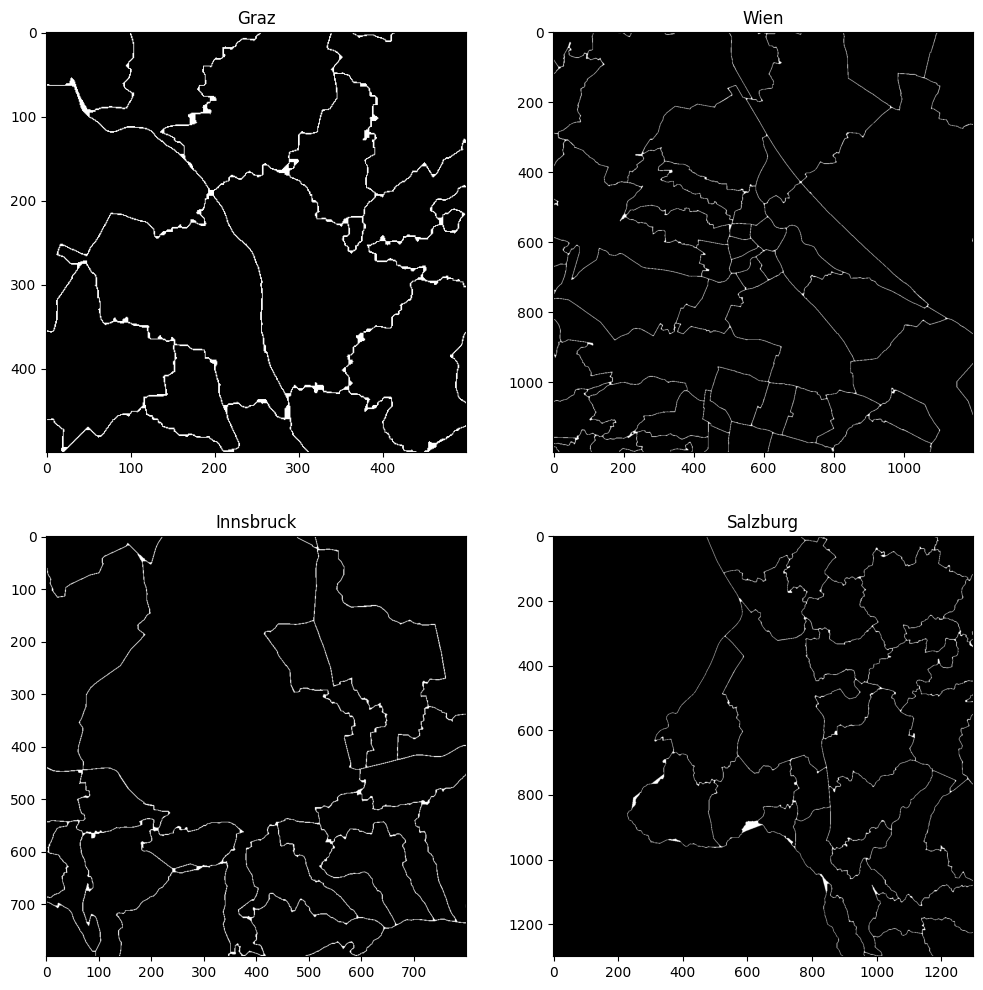

In [5]:
# preprocessing
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, binary_img = cv2.threshold(gray_img, 192, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((5, 5), np.uint8)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

show_regions(binary_img)

In [6]:
def show_contours(contours, image, overlay = False):
    img_with_contours = img.copy() if overlay else np.ones(img.shape, dtype=np.uint8)*255
    cv2.drawContours(img_with_contours, contours, -1, (0,0,255), 1)
    show_regions(img_with_contours)

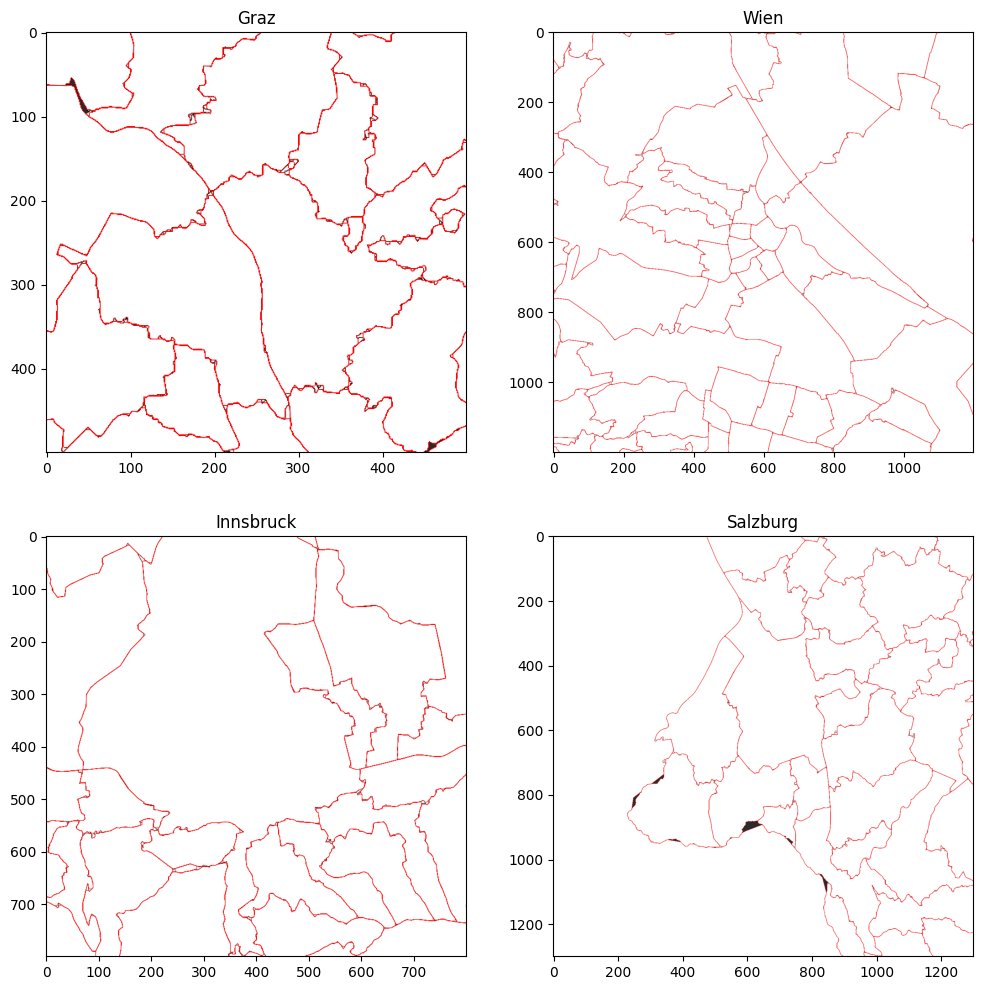

In [7]:
contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

show_contours(contours, img, True)

### Filter Contours

We have found a lot of contours. Some of them are very small and propably due to noise. Therefore we want to get rid of them.

In [8]:
contour_areas = [cv2.contourArea(contour) for contour in contours]

print("before Filtering\n")
print("Number of contours", len(contours))
print("Median", statistics.median(contour_areas))
print("Min", min(contour_areas))
print("Max", max(contour_areas))

before Filtering

Number of contours 2505
Median 53446.5
Min 0.0
Max 186700327.0


After Filtering

Number of contours 2307
Median 57081.5
Min 201.5
Max 494449.0


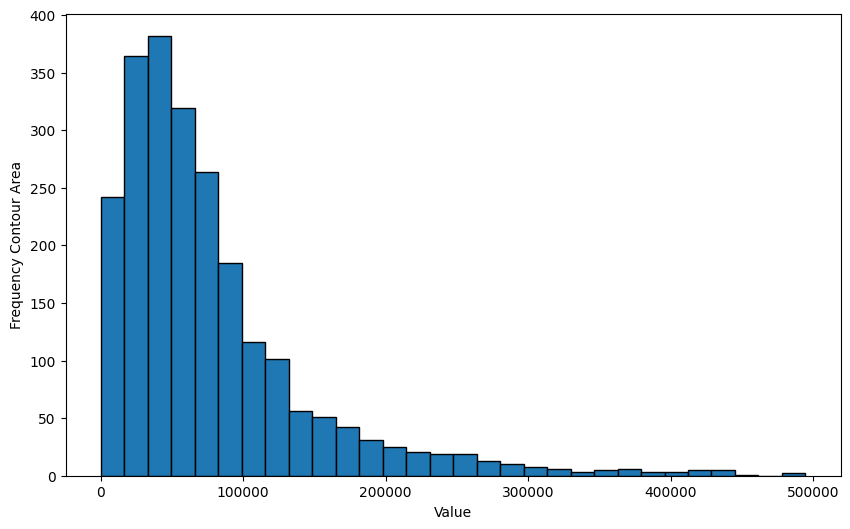

In [9]:
min_area = 200 # trial and error (use show_regions to verify the result)
max_area = 500000 # trial and error (use show_regions to verify the result)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) < max_area and cv2.contourArea(cnt) > min_area]
filtered_contour_areas = [cv2.contourArea(contour) for contour in filtered_contours]

print("After Filtering\n")
print("Number of contours", len(filtered_contours))
print("Median", statistics.median(filtered_contour_areas))
print("Min", min(filtered_contour_areas))
print("Max", max(filtered_contour_areas))

plt.figure(figsize=(10, 6))
plt.hist(filtered_contour_areas, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency Contour Area')
plt.show()

#### Verify Filtered Contours

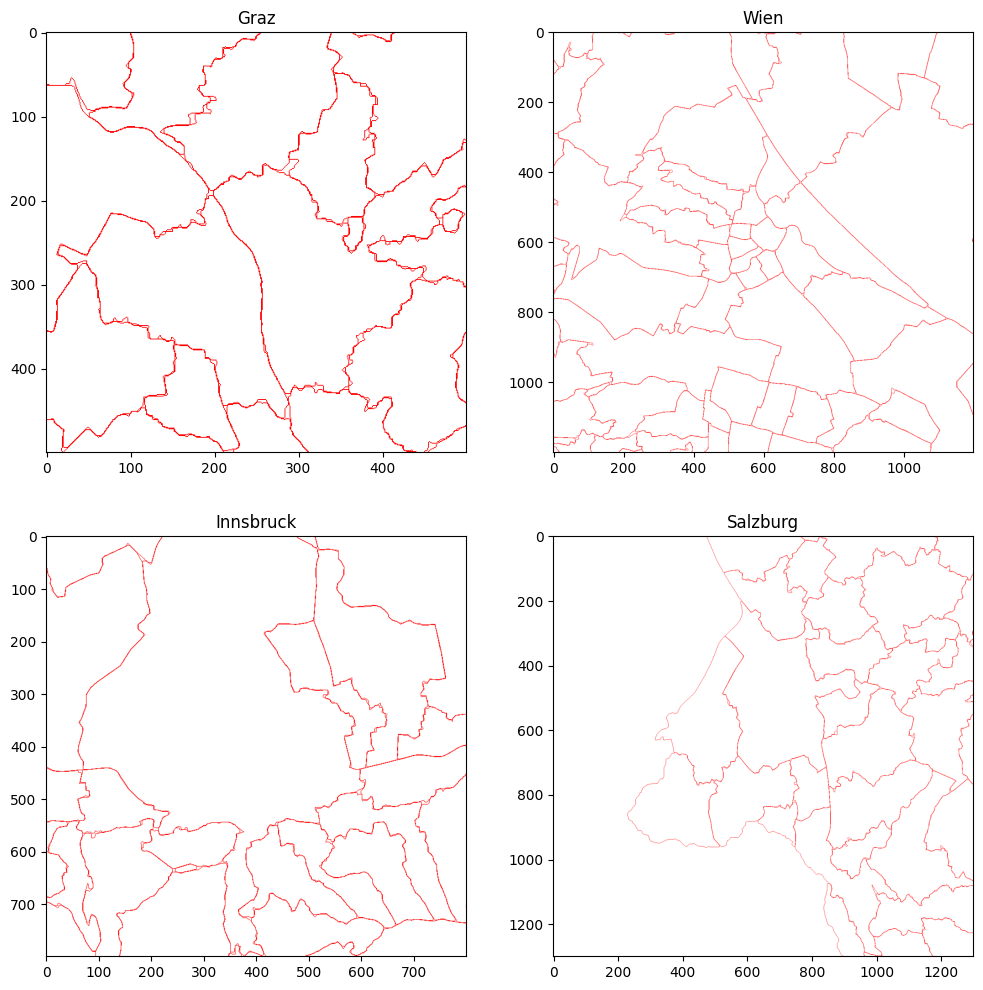

In [10]:
show_contours(filtered_contours, img)

### Simplify (Minify) Contours

Our contours do have a lot of data points and exporting them would be quite inefficient. Therefore we are simplifing the polygons.

In [11]:
# Define approximation accuracy as a percentage of the perimeter of the contour
epsilon_factor = 0.001  # Lower value = higher precision (less simplification)

simplified_contours = []
for contour in filtered_contours:
    epsilon = epsilon_factor * cv2.arcLength(contour, True)  # True means the contour is closed
    approx = cv2.approxPolyDP(contour, epsilon, True)
    simplified_contours.append(approx)

#### Verify Simplified Contours

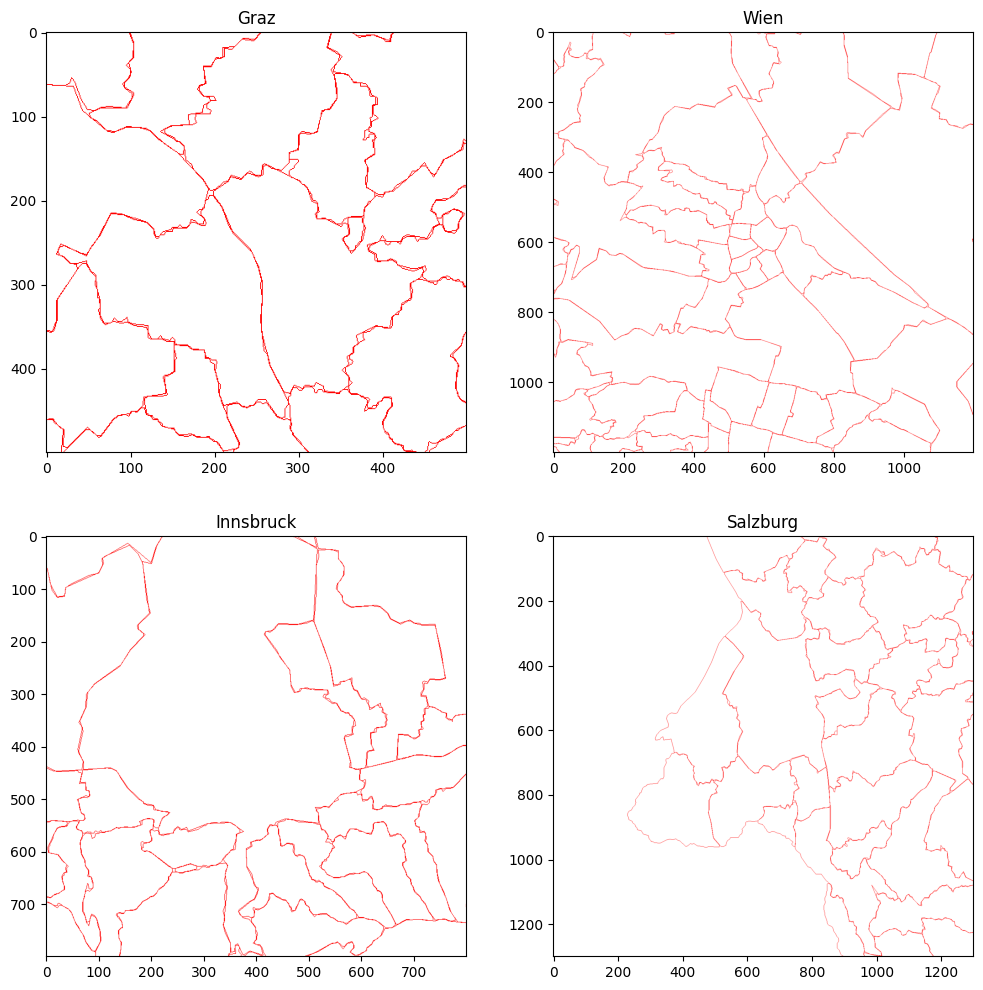

In [12]:
show_contours(simplified_contours, img)

#### Summary

Yay! 🎉 

We found our postal code countours/areas. Now we have to give them a name (e.g. 8010, 8020, etc)

## Mapping the Contours/Areas to the Postal Code Name



### Read the second image file which contains the labels

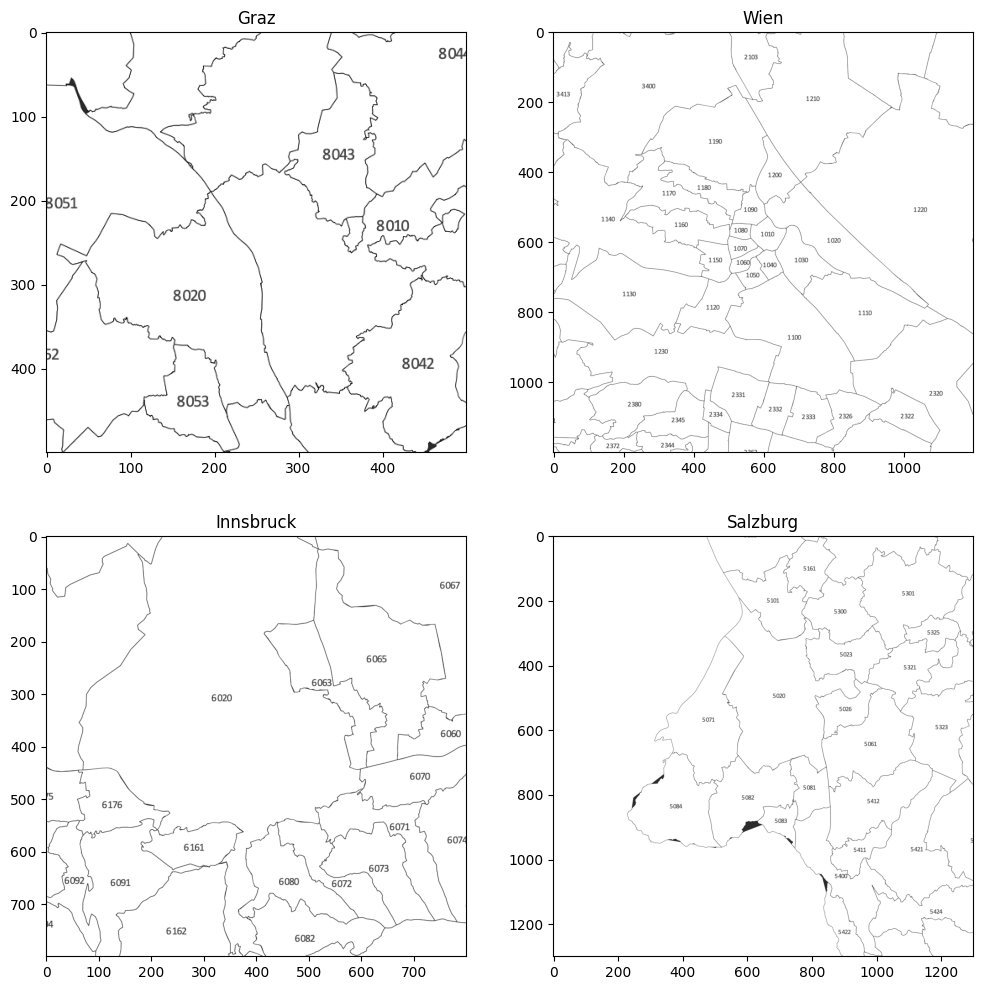

In [13]:
# Read the image with labels
img_with_labels = cv2.imread(str(Path('./input/map-with-labels.png')))

if img_with_labels is None:
    raise FileNotFoundError("Could not read the image file")

if (img.shape != img_with_labels.shape):
    raise ValueError(f"Images must have the same shape. "
                     f"Received shapes: img: {img.shape}, img_with_labels: {img_with_labels.shape}")

show_regions(img_with_labels)

### Mapping Algorithm

This thing not that easy to understand and needed some trial and error.

We are using the following approach:
1. Iterate over contours
    1.  use contour as mask
    2.  crop image
    3.  find postal code in image

In [91]:
def print_progress(step, total):
    clear_output(wait=True)
    if(step % 10 == 0 or step == total):
        print('Contour {step} of {total}'.format(step=step, total=total))

def crop_to_contour(image, contour, padding=10):
    [x, y, w, h] = cv2.boundingRect(contour)
    return image[y-padding:y+h+padding, x-padding:x+w+padding]

def remove_non_digits(string):
    return re.sub(r"\D", "", string)

def is_four_digits(string):
    return bool(re.fullmatch(r"\d{4}", string))

def get_postal_code_from_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Erode everything to make postal code number a single contour
    kernel = np.ones((5, 5), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    max_eroded_postal_code_width = 70
    max_eroded_postal_code_height = 50

    sub_contours, _ = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for sub_contour in sub_contours:
        x, y, w, h = cv2.boundingRect(sub_contour)

        # no need to check big contours => speed things up
        if(w > max_eroded_postal_code_width or h > max_eroded_postal_code_height):
            continue
            
        cropped = binary_image[y:y + h, x:x + w]
        detected_postal_code = pytesseract.image_to_string(cropped, config=r'--oem 3 --psm 6 outputbase digits')
        cleaned_postal_code = remove_non_digits(detected_postal_code)
        if(is_four_digits(cleaned_postal_code)):
            return cleaned_postal_code

In [116]:
contours_by_postal_code = {}
unassigned_contours = []
unassigned_images = []
duplicate_postal_codes = []
for i, contour in enumerate(simplified_contours):
    print_progress(i+1, len(simplified_contours))

    # For debugging: restict to certain region
    # [x, y, w, h] = cv2.boundingRect(contour)
    # if(not(x > 21150 and x+w < 22650 and y > 10782 and y+h < 11500)):
    #     continue
    # print(i)

    outlined_mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(outlined_mask, [contour], -1, (255, 255, 255), 5)

    filled_mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(filled_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
    
    cropped_filled_mask = crop_to_contour(filled_mask, contour)
    cropped_outlined_mask = crop_to_contour(outlined_mask, contour)
    cropped_iwl = crop_to_contour(img_with_labels, contour)

    cropped_masked_iwl = cv2.bitwise_or(cropped_iwl, cropped_outlined_mask) # mask border
    kernel = np.ones((3, 3), np.uint8)
    cropped_filled_mask = cv2.dilate(cropped_filled_mask, kernel, iterations=1)
    cropped_masked_iwl = cv2.bitwise_and(cropped_masked_iwl, cropped_filled_mask) # mask other contours
    
    postal_code = get_postal_code_from_image(cropped_masked_iwl)
    
    if(postal_code):
        if (postal_code in contours_by_postal_code):
            duplicate_postal_codes.append(postal_code)
        contours_by_postal_code[postal_code] = contour
    else:
        unassigned_contours.append(contour)
        unassigned_images.append(cropped_masked_iwl)
        

print("Assigned postal codes", len(contours_by_postal_code))
print("Unassigned contours", len(unassigned_contours))
print("Duplicate postal codes contours", len(duplicate_postal_codes))

Contour 2307 of 2307
Assigned postal codes 2100
Unassigned contours 189
Duplicate postal codes contours 18


### TODO: Post-Processing

We still have some open issues, as we can see in the previous cell:
- the number of assigned postal codes is less than total number of postal codes in Austria?
- proper way to deal with duplicates?

### Summary

Wohoo! 🥳 Now, we have all we need. (the countours and their name)

## Export the Postal Code Contours/Areas

We'll export the data in 3 different formats:
1. .shp files
2. .svg
3. React component

### Export .shp File

In [117]:
height, _, _ = img.shape

with shapefile.Writer("./output/shp/postal-codes-austria.shp") as shp:
    shp.field('ID', 'C')  # Define a field for ID

    for postal_code, contour in contours_by_postal_code.items():
        points = [(int(point[0][0]), height - int(point[0][1])) for point in contour]
        shp.poly([points])
        shp.record(postal_code)

### Export .svg File

In [118]:
# Create SVG
svg = ET.Element('svg')
svg.set('xmlns', 'http://www.w3.org/2000/svg')
svg.set('width', str(img.shape[1]))
svg.set('height', str(img.shape[0]))

style = ET.SubElement(svg, 'style')
style.text = '''
    path {
        fill: none;
        stroke: black;
        stroke-width: 0.5;
    }
'''

# Add contours to SVG
for postal_code, contour in contours_by_postal_code.items():
    path = ET.SubElement(svg, 'path')
    path_data = " ".join(f"{'M' if i == 0 else 'L'} {pt[0][0]} {pt[0][1]}" for i, pt in enumerate(contour))
    path.set('d', f"{path_data} Z")
    path.set('id', postal_code)

# Write SVG to file
tree = ET.ElementTree(svg)
tree.write('output/svg/map.svg', encoding='unicode', xml_declaration=True)

### Export React Component

In [119]:
formatted_path_data_by_postal_code = ""
for postal_code, contour in contours_by_postal_code.items():
    path_data = " ".join(f"{'M' if i == 0 else 'L'} {pt[0][0]} {pt[0][1]}" for i, pt in enumerate(contour))
    formatted_path_data_by_postal_code += "  '{0}': '{1}',\n".format(postal_code, path_data)

reactComponent = """
'use client';

import {{ useEffect, useRef, useState }} from 'react';

export type ChoroplethMapData = {{
  postalCode: string;
  fill?: string;
  stroke?: string;
  tooltip?: string;
}}[];

type Props = {{
  data: ChoroplethMapData;
  width?: string | number;
  height?: string | number;
}}

export function AustriaPostalCodeChoroplethMap({{data, width, height}}: Props) {{
  const svgRef = useRef<SVGSVGElement>(null);
  const [viewBox, setViewBox] = useState('0 0 {width} {height}');

  useEffect(() => {{
    if (svgRef.current) {{
      const svg = svgRef.current;
      const bbox = svg.getBBox();
      setViewBox(`${{bbox.x}} ${{bbox.y}} ${{bbox.width}} ${{bbox.height}}`);
    }}
  }}, [data]);

  return (
    <svg ref={{svgRef}} width={{width}} height={{height}} viewBox={{viewBox}} xmlns="http://www.w3.org/2000/svg">
      {{data.map(({{postalCode, fill, stroke, tooltip}}) => (
        pathDataByPostalCode[postalCode] ? (
          <path key={{postalCode}} d={{pathDataByPostalCode[postalCode]}} fill={{fill}} stroke={{stroke}}>
            {{tooltip ? <title>{{tooltip}}</title> : null}}
          </path>
        ) : null
      ))}}
    </svg>
  )
}}

const pathDataByPostalCode: Record<string, string> = {{
{formatted_path_data_by_postal_code}
}}
""".format(width=img.shape[1], height=img.shape[0], formatted_path_data_by_postal_code=formatted_path_data_by_postal_code)

with open("output/react/austria-postal-code-choropleth-map.tsx", "w") as text_file:
    text_file.write(reactComponent)

## Final Summary ✅

We started with two images and used some clever image processing in order to automatically generate the required output files. (.shp data containing the postal code areas of Austria)

An example application can be found at: [immo-preise.at](https://www.immo-preise.at/)

(The postal code areas might change over time. => The output files can be easily updated by using this notebook.)